# Trying Bootstrap Your Own Latent (BYOL) on CIFAR-10

In [14]:
import time

from os import path

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18

data_root = '/home/fcfschulz/Documents/workspace/data/Vision/torchvision_ds/'
save_root = './results/byol/'

### For COLAB ############################################################
#from google.colab import drive
#drive.mount('/content/drive')
#
#data_root = './'
#save_root ='./drive/MyDrive/Colab_Notebooks/PhD/SSL_pytorch/results/byol/'
#
# !cp -r ./drive/MyDrive/Colab_Notebooks/PhD/SSL_pytorch/* ./
##########################################################################

from augmentation import BYOL_augmentaions
from models import BYOL
from optimizer import LARS
from utils import check_existing_model, Linear_Protocoler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Print Device Type
if torch.cuda.is_available():
    print(f"Program running on {torch.cuda.get_device_name(device)}")
else:
    print("Program running on CPU")

    
# Define hyperparameters
dl_kwargs = {'batch_size': 512, 'shuffle': True, 'num_workers': 2}

optim_params = {'lr':0.2 * dl_kwargs['batch_size']/256,
                'weight_decay': 1.5e-6,
                'exclude_bias_and_norm':True}
train_params = {'num_epochs': 400, 'warmup_epchs': 10, 'eta_min':1e-3}
eval_params  = {'lr':1e-2, 'num_epochs': 5}

Program running on CPU


# BYOL
### Define Augmentation and Datasets

In [15]:
# Cifar10 Mean and Std
CIFAR10_NORM = [[0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]]

# Define Augmentations
train_transf = BYOL_augmentaions(image_size=32, normalize=CIFAR10_NORM)

train_eval_transf = transforms.Compose([
    transforms.RandomResizedCrop(32, (0.8, 1.),interpolation=transforms.InterpolationMode('bicubic')),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(*CIFAR10_NORM)])

test_transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*CIFAR10_NORM)])

# Define Datasets
train_ds = CIFAR10(root=data_root, train = True, download = True, transform = train_transf)
train_eval_ds = CIFAR10(root=data_root, train = True, transform = train_eval_transf, download = True)
test_ds  = CIFAR10(root=data_root, train = False, transform = test_transf, download = True)

# Define Dataloaders
train_dl = DataLoader(train_ds, drop_last=True, **dl_kwargs)
train_eval_dl = DataLoader(train_eval_ds, drop_last=False, **dl_kwargs)
test_dl  = DataLoader(test_ds, drop_last=False, **dl_kwargs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define model

In [6]:
resnet = resnet18(zero_init_residual=True)
repre_dim = resnet.fc.in_features

# Inspired from SimSiam
byol = BYOL(resnet,
            projector_hidden = (2048, 2048),
            predictor_hidden = (512, 2048)).to(device)

### Define Optimizer & Scheduler

In [7]:
optimizer = LARS(byol.parameters(), **optim_params)

# Define scheduler for warmup
scheduler = lr_scheduler.LambdaLR(optimizer, lambda it : (it+1)/(train_params['warmup_epchs']*len(train_dl)))

### Check for trained model

In [8]:
# Init
lp_acc = []
loss_hist = []
lr_hist = []
tau_hist = []

epoch_start, saved_data = check_existing_model(save_root, device)
if saved_data:
    # Extract data
    byol.load_state_dict(saved_data['model'])
    optimizer.load_state_dict(saved_data['optim'])
    if epoch_start >= train_params['warmup_epchs']:
        iters_left = (train_params['num_epochs']-train_params['warmup_epchs'])*len(train_dl)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                   iters_left,
                                                   eta_min=train_params['eta_min'])
    scheduler.load_state_dict(saved_data['sched'])
    lp_acc = saved_data['lp_acc']
    loss_hist = saved_data['loss_hist']
    lr_hist = saved_data['lr_hist']
    tau_hist = saved_data['tau_hist']

Pretrained model available, use it?[y/n]: y


### Training

In [ ]:
# Run linear protocol for random init model
if len(lp_acc)==0:
    linear_proto = Linear_Protocoler(byol.backbone_net, out_dim=repre_dim)
    linear_proto.train(train_eval_dl, eval_params['num_epochs'], eval_params['lr'])
    lp_acc.append(linear_proto.get_accuracy(test_dl))
    print(f'Accuracy after init: {100*lp_acc[-1]}')
    
# get total number of iterations
total_iters = train_params['num_epochs'] * len(train_dl)

# Run Training
for epoch in range(epoch_start, train_params['num_epochs']):
    epoch_loss = 0
    start_time = time.time()
    for i, ((x1,x2), _) in enumerate(train_dl):
        x1,x2 = x1.to(device), x2.to(device)
        
        # Forward pass
        loss = byol(x1,x2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update momentum encoder
        # get τ
        τ = byol.get_tau(1+i+len(train_dl)*epoch,total_iters)
        byol.update_moving_average(τ)
        tau_hist.append(τ)
        
        # Scheduler every iteration for cosine deday
        scheduler.step()
        
        # Save loss and LR
        epoch_loss += loss.item()
        lr_hist.extend(scheduler.get_last_lr())
    
    # Switch to Cosine Decay after warmup period
    if epoch+1==train_params['warmup_epchs']:
        iters_left = (train_params['num_epochs']-train_params['warmup_epchs'])*len(train_dl)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                       iters_left,
                                                       eta_min=train_params['eta_min'])
    
    # Log
    loss_hist.append(epoch_loss/len(train_dl))
    print(f'Epoch: {epoch}, Loss: {loss_hist[-1]}, Time epoch: {time.time() - start_time}')
    
    # Run linear protocol and save stats
    if (epoch+1)%5==0:
        # Linear protocol
        linear_proto = Linear_Protocoler(byol.backbone_net, out_dim=repre_dim)
        linear_proto.train(train_eval_dl, eval_params['num_epochs'], eval_params['lr'])
        lp_acc.append(linear_proto.get_accuracy(test_dl))
        print(f'Accuracy after epoch {epoch}: {100*lp_acc[-1]}')
        
        torch.save({'model':byol.state_dict(),
                    'optim': optimizer.state_dict(),
                    'sched': scheduler.state_dict(),
                    'lp_acc': lp_acc,
                    'loss_hist': loss_hist,
                    'lr_hist': lr_hist,
                    'tau_hist': tau_hist}, 
                   path.join(save_root, f'epoch_{epoch+1:03}.tar'))

### Visualize loss, eval accuracy, learning rate and $\tau$

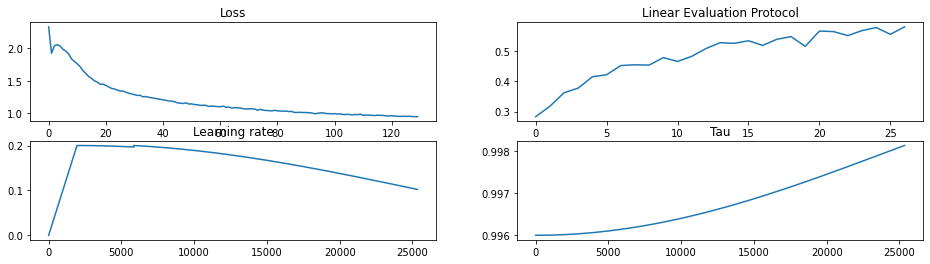

In [9]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,4))
ax1.plot(loss_hist)
ax1.set_title("Loss")

ax2.plot(lp_acc)
ax2.set_title("Linear Evaluation Protocol")

ax3.plot(lr_hist)
ax3.set_title("Learning rate")

ax4.plot(tau_hist)
ax4.set_title("Tau")

plt.show()